In [ ]:
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.nn import TripletMarginLoss

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
data_dir = "/content/drive/MyDrive/DeepLearning/Final/Datasets/train"

In [ ]:
class TripletFaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = {
            cls: [os.path.join(root_dir, cls, img)
                  for img in os.listdir(os.path.join(root_dir, cls))
                  if img.lower().endswith(('jpg', 'jpeg', 'png'))]
            for cls in self.classes
        }

    def __len__(self):
        return sum(len(v) for v in self.image_paths.values())

    def __getitem__(self, idx):
        anchor_class = random.choice(self.classes)
        positive_class = anchor_class
        negative_class = random.choice([c for c in self.classes if c != anchor_class])

        anchor_path = random.choice(self.image_paths[anchor_class])
        positive_path = random.choice([p for p in self.image_paths[positive_class] if p != anchor_path])
        negative_path = random.choice(self.image_paths[negative_class])

        anchor_img = Image.open(anchor_path).convert("RGB")
        positive_img = Image.open(positive_path).convert("RGB")
        negative_img = Image.open(negative_path).convert("RGB")

        if self.transform:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)

        return anchor_img, positive_img, negative_img

In [ ]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 34 * 34, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [ ]:
class TripletNet(nn.Module):
    def __init__(self, embedding_net):
        super(TripletNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, anchor, positive, negative):
        anchor_out = self.embedding_net(anchor)
        positive_out = self.embedding_net(positive)
        negative_out = self.embedding_net(negative)
        return anchor_out, positive_out, negative_out

In [ ]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

In [ ]:
dataset = TripletFaceDataset(data_dir, transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
model = TripletNet(EmbeddingNet()).to(device)
criterion = TripletMarginLoss(margin=1.0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for anchor, positive, negative in loader:
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        out_a, out_p, out_n = model(anchor, positive, negative)

        loss = criterion(out_a, out_p, out_n)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss:.4f}")

Epoch 1/10 - Loss: 25.1384
Epoch 2/10 - Loss: 14.1152
Epoch 3/10 - Loss: 9.7973
Epoch 4/10 - Loss: 7.4533
Epoch 5/10 - Loss: 6.4311
Epoch 6/10 - Loss: 4.1397
Epoch 7/10 - Loss: 2.9881
Epoch 8/10 - Loss: 1.4406
Epoch 9/10 - Loss: 1.6828
Epoch 10/10 - Loss: 1.7172


In [ ]:
torch.save(model.state_dict(), "triplet_face_model.pth")

# valid

In [ ]:
with torch.no_grad():
    f1 = model.embedding_net(anchor).squeeze().cpu().numpy().flatten()
    f2 = model.embedding_net(positive).squeeze().cpu().numpy().flatten()
    f3 = model.embedding_net(negative).squeeze().cpu().numpy().flatten()

In [ ]:
print("f1 (anchor embedding):", f1)
print("f2 (positive embedding):", f2)
print("f3 (negative embedding):", f3)

f1 (anchor embedding): [ 0.7966993   0.44639972  0.14574234 ... -0.16312627  0.46472913
 -0.32358542]
f2 (positive embedding): [ 0.76877564  0.5217861  -0.02580286 ... -0.05731053  0.3271698
 -0.2555703 ]
f3 (negative embedding): [-0.45146647  0.7732749   0.34685376 ... -0.60829407  0.43780208
  0.2843327 ]


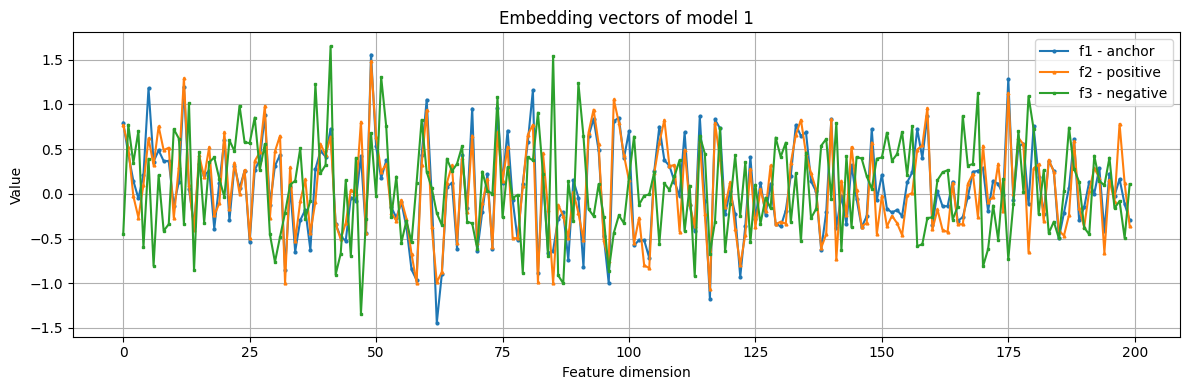

In [ ]:
dim_to_plot = 200
plt.figure(figsize=(12, 4))
plt.plot(f1[:dim_to_plot], label='f1 - anchor', marker='o', markersize=2)
plt.plot(f2[:dim_to_plot], label='f2 - positive', marker='^', markersize=2)
plt.plot(f3[:dim_to_plot], label='f3 - negative', marker='s', markersize=2)
plt.title(f"Embedding vectors of model 1")
plt.xlabel("Feature dimension")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
sim_ap = F.cosine_similarity(torch.tensor(f1), torch.tensor(f2), dim=0).item()
sim_an = F.cosine_similarity(torch.tensor(f1), torch.tensor(f3), dim=0).item()
print(f"Cosine Similarity (f1 vs f2): {sim_ap:.4f}")
print(f"Cosine Similarity (f1 vs f3): {sim_an:.4f}")

Cosine Similarity (f1 vs f2): 0.8469
Cosine Similarity (f1 vs f3): -0.0095


3d

In [ ]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

embeddings = []
labels = []  # 0 - anchor, 1 - positive, 2 - negative

model.eval()
with torch.no_grad():
    for i in range(50):  # lấy 50 batch hoặc bao nhiêu tuỳ bạn
        anchor, positive, negative = next(iter(loader))
        anchor = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)

        emb_a = model.embedding_net(anchor).cpu().numpy()
        emb_p = model.embedding_net(positive).cpu().numpy()
        emb_n = model.embedding_net(negative).cpu().numpy()

        embeddings.extend(emb_a)
        embeddings.extend(emb_p)
        embeddings.extend(emb_n)

        labels.extend([0] * len(emb_a))  # anchor
        labels.extend([1] * len(emb_p))  # positive
        labels.extend([2] * len(emb_n))  # negative


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


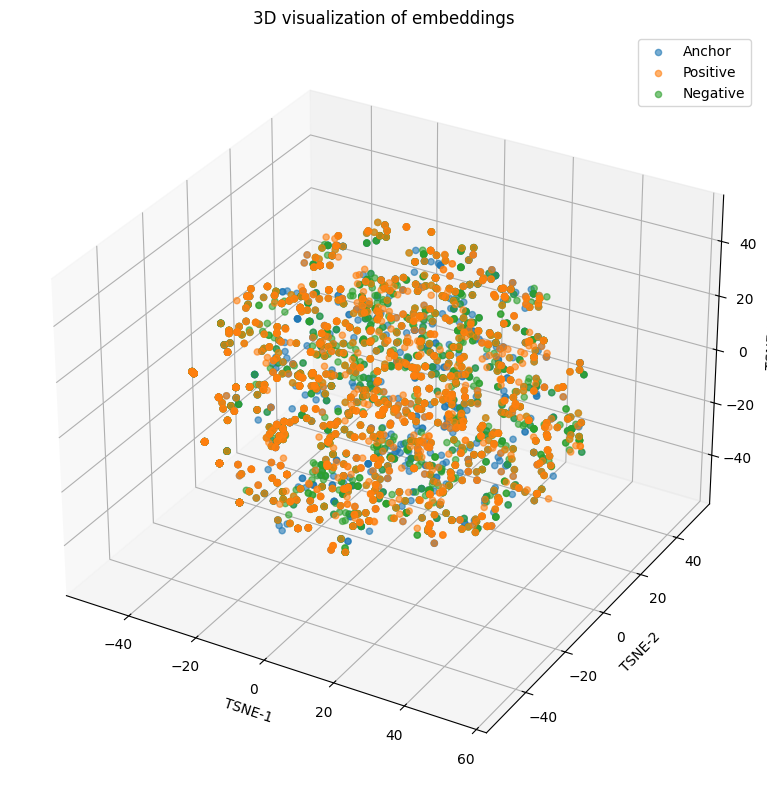

In [ ]:
# Sử dụng t-SNE 3D
tsne = TSNE(n_components=3, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
emb_3d = tsne.fit_transform(np.array(embeddings))

# Vẽ biểu đồ 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = ['blue', 'orange', 'green']
labels_text = ['Anchor', 'Positive', 'Negative']

for label_id in range(3):
    idx = [i for i, l in enumerate(labels) if l == label_id]
    ax.scatter(
        emb_3d[idx, 0],
        emb_3d[idx, 1],
        emb_3d[idx, 2],
        label=labels_text[label_id],
        alpha=0.6,
        s=20
    )

ax.set_title("3D visualization of embeddings")
ax.set_xlabel("TSNE-1")
ax.set_ylabel("TSNE-2")
ax.set_zlabel("TSNE-3")
ax.legend()
plt.tight_layout()
plt.show()
